# Auswertung 27.05.2025
Auswertung mit vergleich von TBBB TCBC und LNO

## Präambel

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.optimize import curve_fit

import glob
import re

def dat2array(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for i, line in enumerate(file):
            line = line.replace(',', '.').replace('\t', ';').replace('\n', '')
            if i >= 39:  # Skip header lines
                data.append(line.split(';'))

    freqs = [float(row[0]) for row in data]
    intensities = [float(row[1]) for row in data]
    return freqs, intensities
    
def extract_info(filename):
    match = re.search(r'0(\d+)_(\d+)K\.asc', filename)
    if match:
        return int(match.group(1)), int(match.group(2))
    return None, None

def gaussian(x, a, mean, sigma):
    return a * np.exp(-(x - mean) ** 2 / (2 * sigma ** 2))

In [6]:
 # Hilfsfunktion: FWHM aus diskreten Daten via linearer Interpolation bestimmen
def _compute_fwhm_from_discrete(x, y, ymax=None):
    if x is None or y is None or len(x) == 0 or len(y) == 0:
        return None
    if ymax is None:
        ymax = max(y)
    half = ymax / 2.0
    idx_max = int(np.argmax(y))
    # Linke Halbwertsstelle
    left = None
    for i in range(idx_max, 0, -1):
        y1, y2 = y[i-1], y[i]
        if (y1 - half) * (y2 - half) <= 0:  # Vorzeichenwechsel bzw. Schnitt
            x1, x2 = x[i-1], x[i]
            if y2 != y1:
                left = x1 + (half - y1) * (x2 - x1) / (y2 - y1)
            else:
                left = x[i]
            break
    # Rechte Halbwertsstelle
    right = None
    for i in range(idx_max, len(y) - 1):
        y1, y2 = y[i], y[i+1]
        if (y1 - half) * (y2 - half) <= 0:
            x1, x2 = x[i], x[i+1]
            if y2 != y1:
                right = x1 + (half - y1) * (x2 - x1) / (y2 - y1)
            else:
                right = x[i]
            break
    if left is None or right is None:
        return None
    return abs(right - left)

In [7]:
def create_shg_plot(middle_value, difference, filepath, suptitle, filename_prefix, reference=False, compare=True, power="333µW", slit_width="210µm", normalisationfactor=131942273.14285715, refmeas="LiNbO₃-SHG"):
    x_range = (middle_value - difference, middle_value + difference)
    file_list = glob.glob(filepath)

    sorted_files = []
    for f in file_list:
        meas_no, temperature = extract_info(f)
        if meas_no is not None:
            sorted_files.append((f, meas_no, temperature))

    sorted_files.sort(key=lambda x: x[1])
    
    extended_files = []
    heating = True
    for f, meas_no, temperature in sorted_files:
        if heating and temperature > 435:
            heating = False
        extended_files.append((f, meas_no, temperature, heating))

    temperatures = [x[2] for x in sorted_files]
    if len(temperatures) == 0:
        print("Keine Dateien gefunden, die dem Pfad entsprechen.")
        return
    norm = plt.Normalize(min(temperatures), max(temperatures))
    colors = cm.plasma(norm(temperatures))

    # Bestimme zuerst das absolute Maximum aus den Rohdaten im gezeigten Fenster
    # (vor jeglicher Referenz-/Normalisierungs- bzw. Skalierungsanpassung)
    absolute_max_raw = None
    for f, meas_no, temperature, heating in extended_files:
        freqs_tmp, ints_tmp = dat2array(f)
        # Rohdaten verwenden - keine Referenz oder Normalisierung anwenden
        vals = [i for fr, i in zip(freqs_tmp, ints_tmp) if x_range[0] <= fr <= x_range[1]]
        if vals:
            local_max = max(vals)
            if absolute_max_raw is None or local_max > absolute_max_raw:
                absolute_max_raw = local_max
    if absolute_max_raw is None:
        absolute_max_raw = 0.0
    print(f"Absolute maximum in raw data within x_range {x_range}: {absolute_max_raw}")

    # Wenn compare=False: zähle zusätzlich das globale Maximum im gezeigten Fenster (kann andere Skalierung nutzen)
    global_max = 0.0
    if not compare:
        for f, meas_no, temperature, heating in extended_files:
            freqs_tmp, ints_tmp = dat2array(f)
            if reference:
                ints_tmp = [val * 32.88 * (10/7) for val in ints_tmp]
            # Filter auf das gezeigte Fenster
            vals = [i for fr, i in zip(freqs_tmp, ints_tmp) if x_range[0] <= fr <= x_range[1]]
            if vals:
                local_max = max(vals)
                if local_max > global_max:
                    global_max = local_max
        if global_max <= 0:
            global_max = 1.0

    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 5))
    peak_list = []
    temps_for_line = []
    peaks_for_line = []
    
    # Sammle Peak-Parameter je Messung für spätere Zusammenfassung
    peak_metrics = []  # Einträge: dict(height, area, mean, fwhm, temperature, fit_success)

    for idx, (f, meas_no, temperature, heating) in enumerate(extended_files):
        freqs, intensities = dat2array(f)
        # optionale Referenzskalierung (z.B. ND2 und Zeitkorrektur)
        if reference:
            intensities = [val * 32.88 * (10/7) for val in intensities]

        # falls Vergleichsmodus an, normalisiere wie vorher relativ zu LNO (Konstante bleibt)
        if compare:
            intensities = [val / normalisationfactor for val in intensities]

        # Filtere nur das gezeigte Fenster (wichtig!)
        filtered_data = [(fr, i) for fr, i in zip(freqs, intensities) if x_range[0] <= fr <= x_range[1]]
        filtered_freqs, filtered_intensities = zip(*filtered_data) if filtered_data else ([], [])

        if not filtered_data:
            continue

        # falls compare=False -> skaliere alle Messdaten relativ zum globalen Maximum im Fenster
        if not compare:
            if global_max <= 0:
                scale = 1.0
            else:
                scale = global_max
            filtered_intensities = [v / scale for v in filtered_intensities]
        else:
            filtered_intensities = list(filtered_intensities)

        filtered_freqs = list(filtered_freqs)

        ax0.plot(filtered_freqs, filtered_intensities, color='lightgray')  # Plot in Hellgrau

        # --- Temperaturwert für rechten Plot vorbereiten ---
        temp_for_plot = temperature if heating else (880 - temperature)

        try:
            popt, _ = curve_fit(gaussian, filtered_freqs, filtered_intensities,
                                p0=[max(filtered_intensities), np.mean(filtered_freqs), 10])
            fitted_curve = gaussian(np.array(filtered_freqs), *popt)
            ax0.plot(filtered_freqs, fitted_curve, color=colors[idx])
            area = np.trapezoid(fitted_curve, filtered_freqs)
            ax1.scatter(temp_for_plot, area, color='black', marker='o')

            # Peak-Parameter aus Fit
            a_fit, mean_fit, sigma_fit = float(popt[0]), float(popt[1]), abs(float(popt[2]))
            fwhm_fit = 2.0 * np.sqrt(2.0 * np.log(2.0)) * sigma_fit
            peak_metrics.append({
                'height': a_fit,
                'area': float(area),
                'mean': mean_fit,
                'fwhm': float(fwhm_fit),
                'temperature': temperature,
                'fit_success': True,
            })
        except RuntimeError:
            ax0.plot(filtered_freqs, filtered_intensities, color=colors[idx])
            area = np.trapezoid(filtered_intensities, filtered_freqs)
            ax1.scatter(temp_for_plot, area, color='black', marker='x')

            # Peak-Parameter ohne Fit (robuste Schätzung)
            if filtered_intensities and filtered_freqs:
                height_nf = float(max(filtered_intensities))
                mean_nf = float(filtered_freqs[int(np.argmax(filtered_intensities))])
                # Lokale FWHM-Schätzung per Interpolation
                def _compute_fwhm_from_discrete_local(x, y, ymax=None):
                    if x is None or y is None or len(x) == 0 or len(y) == 0:
                        return None
                    if ymax is None:
                        ymax = max(y)
                    half = ymax / 2.0
                    idx_max = int(np.argmax(y))
                    left = None
                    for i in range(idx_max, 0, -1):
                        y1, y2 = y[i-1], y[i]
                        if (y1 - half) * (y2 - half) <= 0:
                            x1, x2 = x[i-1], x[i]
                            if y2 != y1:
                                left = x1 + (half - y1) * (x2 - x1) / (y2 - y1)
                            else:
                                left = x[i]
                            break
                    right = None
                    for i in range(idx_max, len(y) - 1):
                        y1, y2 = y[i], y[i+1]
                        if (y1 - half) * (y2 - half) <= 0:
                            x1, x2 = x[i], x[i+1]
                            if y2 != y1:
                                right = x1 + (half - y1) * (x2 - x1) / (y2 - y1)
                            else:
                                right = x[i]
                            break
                    if left is None or right is None:
                        return None
                    return abs(right - left)
                fwhm_nf = _compute_fwhm_from_discrete_local(list(filtered_freqs), list(filtered_intensities), ymax=height_nf)
                peak_metrics.append({
                    'height': height_nf,
                    'area': float(area),
                    'mean': mean_nf,
                    'fwhm': float(fwhm_nf) if fwhm_nf is not None else None,
                    'temperature': temperature,
                    'fit_success': False,
                })

        peak_list.append(area)
        temps_for_line.append(temp_for_plot)
        peaks_for_line.append(area)

    sm = plt.cm.ScalarMappable(cmap=cm.plasma, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax0, orientation='vertical', pad=0.02)
    cbar.set_label('Temperature in K')
    cbar.set_ticks([min(temperatures), max(temperatures)])
    cbar.set_ticklabels([f"{min(temperatures)} K", f"{max(temperatures)} K"])

    # Finde Index, an dem heating von True auf False wechselt
    heating_flags = [ht for (_, _, _, ht) in extended_files]
    if True in heating_flags and False in heating_flags:
        split_idx = heating_flags.index(False)
        ax1.plot(temps_for_line[:split_idx+1], peaks_for_line[:split_idx+1],
                 color='red', linewidth=1.2, alpha=0.5, zorder=0)
        ax1.plot(temps_for_line[split_idx:], peaks_for_line[split_idx:],
                 color='blue', linewidth=1.2, alpha=0.5, zorder=0)
    else:
        color = 'red' if all(heating_flags) else 'blue'
        ax1.plot(temps_for_line, peaks_for_line, color=color, linewidth=2, alpha=0.7, zorder=0)

    # set x- and y-axis limits and labels
    ax0.set_xlim(x_range)
    ax0.set_ylim(bottom=0)
    ax0.set_xlabel('Wavelength in nm')
    ax1.set_xlabel('Temperature in K')

    # Achsenbeschriftung abhängig vom compare-Flag
    if compare:
        ax0.set_ylabel(f'rel. Int. to {refmeas}')
        ax1.set_ylabel(f'Area of Gaussian Fit rel. to {refmeas}')
    else:
        ax0.set_ylabel('Intensity in arb. u.')
        ax1.set_ylabel('Area of Gaussian Fit in arb. u.')

    fig.suptitle(suptitle, fontsize=16)
    fig.text(0.5, 0.914, f"Measurement parameters: Power: {power}, Slit width={slit_width}", ha="center")

    # Zusammenfassung unterhalb der Diagramme anzeigen
    if len(peak_metrics) > 0:
        # Peak für die Zusammenfassung anhand der größten Fläche wählen (nur im gezeigten Fenster berechnet)
        best = max(peak_metrics, key=lambda d: d.get('area', float('-inf')))
        lam0 = best.get('mean', None)
        fwhm = best.get('fwhm', None)
        hoehe = best.get('height', None)
        flaeche = best.get('area', None)
        unit = 'arb. u.' if (reference or not compare) else 'rel.'
        parts = []
        if lam0 is not None:
            parts.append(f"Zentralwellenlänge: {lam0:.2f} nm")
        if fwhm is not None:
            parts.append(f"FWHM: {fwhm:.2f} nm")
        # Bei compare=False sollen Höhe und Fläche im Info-Kasten weggelassen werden
        if compare:
            if hoehe is not None:
                parts.append(f"Höhe: {hoehe:.3g} {unit}")
            if flaeche is not None:
                parts.append(f"Fläche: {flaeche:.3g} {unit}·nm")

        info_text = "   |   ".join(parts) if parts else ""
        if info_text:
            fig.subplots_adjust(bottom=0.18)
            fig.text(0.5, 0.01, info_text, ha='center', va='bottom',
                     fontsize=10,
                     bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='lightgray'))

    plt.show()

    fig.savefig(f'./{filename_prefix}.png', dpi=600, bbox_inches='tight')
    fig.savefig(f'./{filename_prefix}.pdf', dpi=600, bbox_inches='tight')
    

## TBBB

Absolute maximum in raw data within x_range (665, 735): 370.0


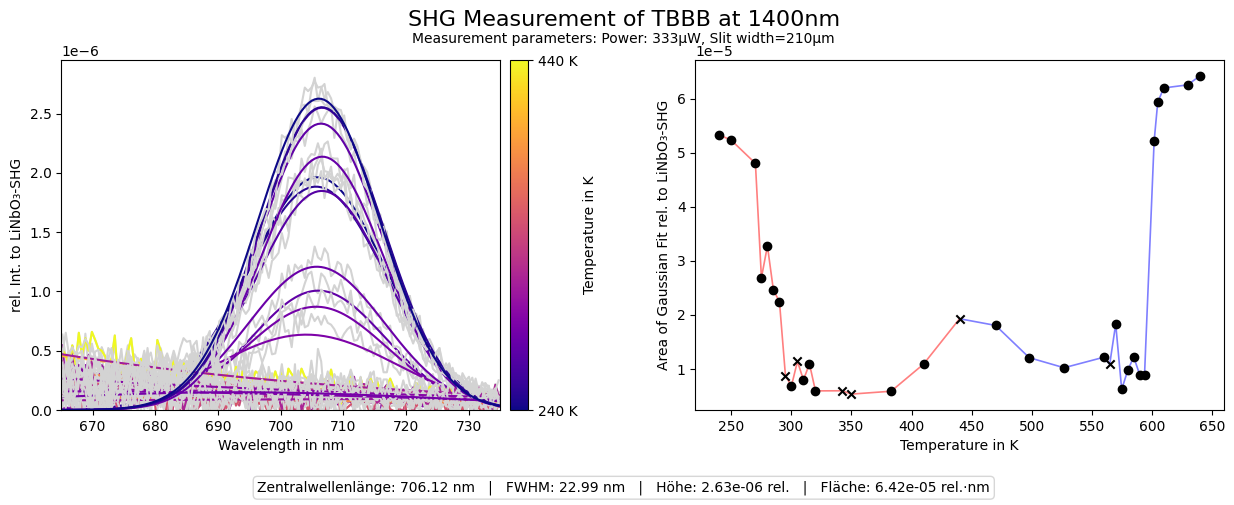

In [8]:
create_shg_plot(
    middle_value=700,
    difference=35,
    filepath='2025-05-22 TBBB/1400nm/0.333mW_Spalt210um/*.asc',
    suptitle='SHG Measurement of TBBB at 1400nm',
    filename_prefix='TBBB_SHG'
)

Absolute maximum in raw data within x_range (432, 502): 2580.0


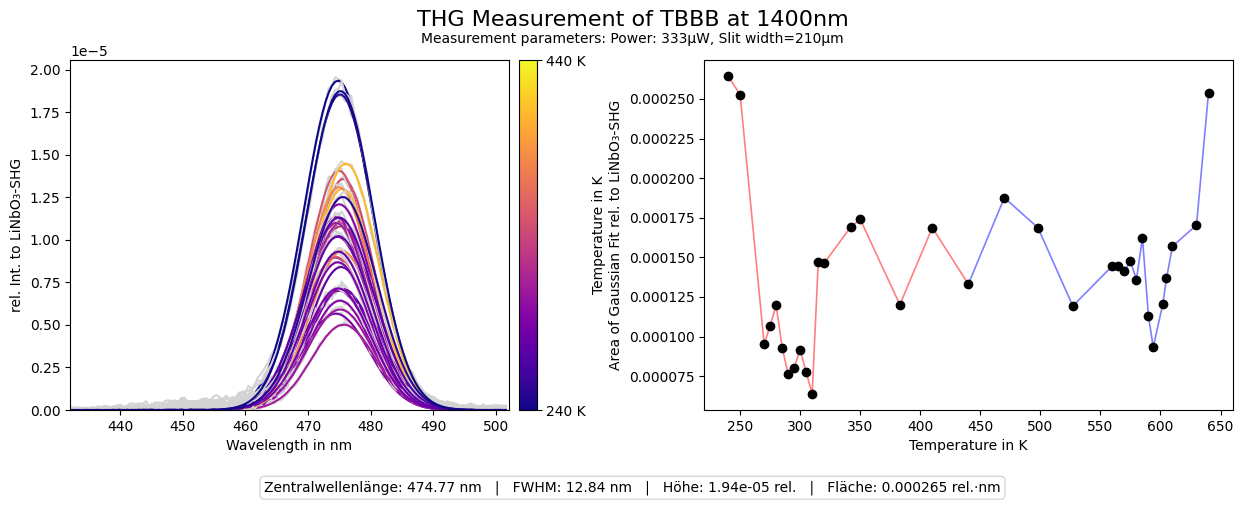

In [9]:
create_shg_plot(
    middle_value=467,
    difference=35,
    filepath='2025-05-22 TBBB/1400nm/0.333mW_Spalt210um/*.asc',
    suptitle='THG Measurement of TBBB at 1400nm',
    filename_prefix='TBBB_THG'
)

## TCBC

Absolute maximum in raw data within x_range (665, 735): 10023.0


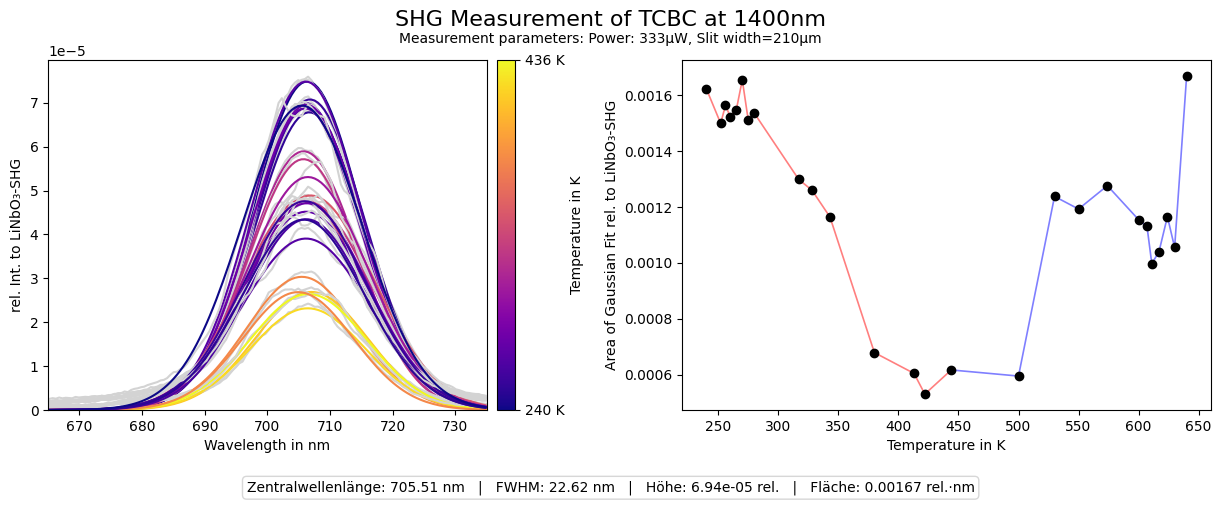

In [10]:
create_shg_plot(
    middle_value=700,
    difference=35,
    filepath='2025-05-23 TCBC/1400nm/0.333mW_Spalt210um/*.asc',
    suptitle='SHG Measurement of TCBC at 1400nm',
    filename_prefix='TCBC_SHG'
)

Absolute maximum in raw data within x_range (432, 502): 2894.0


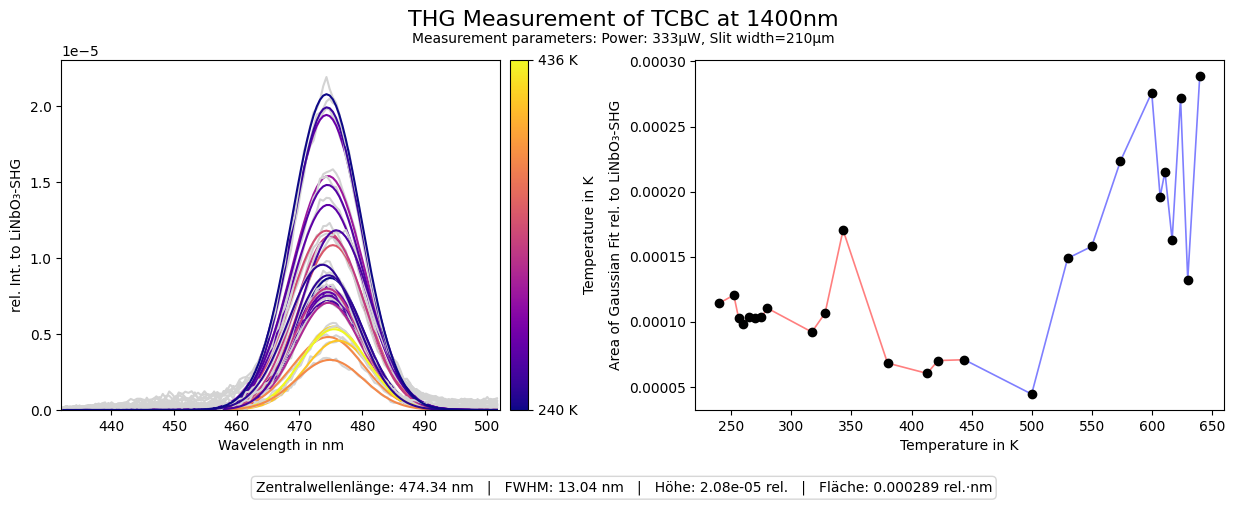

In [11]:
create_shg_plot(
    middle_value=467,
    difference=35,
    filepath='2025-05-23 TCBC/1400nm/0.333mW_Spalt210um/*.asc',
    suptitle='THG Measurement of TCBC at 1400nm',
    filename_prefix='TCBC_THG'
)

## LNO

#### Vergleichsmessung

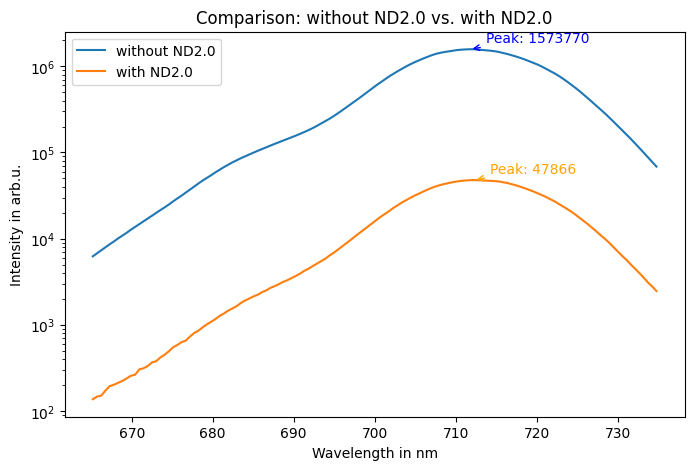

Skalierungsfaktor (ohne ND2.0 / mit ND2.0): 32.88


In [12]:
# Definiere den Wellenlängenbereich wie bei LNO SHG
x_range = (700 - 35, 700 + 35) # anpassen falls verändert!

# Lade die Vergleichsmessungen "mit" und "ohne" ND2.0:
files_ohne = glob.glob('2025-05-23 LNO/1400nm/0.333mW_Spalt210um/Vergleichsmessung ND2.0/ohne*.asc')
files_mit = glob.glob('2025-05-23 LNO/1400nm/0.333mW_Spalt210um/Vergleichsmessung ND2.0/mit*.asc')

# Wähle jeweils die erste Datei (ggf. anpassen, falls mehrere vorhanden)
file_ohne = files_ohne[0]
file_mit = files_mit[0]

# Lade die Daten
freqs_ohne, intensities_ohne = dat2array(file_ohne)
freqs_mit, intensities_mit = dat2array(file_mit)

# Filtere den Bereich wie bei x_range
filtered_data_ohne = [(fr, i) for fr, i in zip(freqs_ohne, intensities_ohne) if x_range[0] <= fr <= x_range[1]]
filtered_data_mit = [(fr, i) for fr, i in zip(freqs_mit, intensities_mit) if x_range[0] <= fr <= x_range[1]]

filtered_freqs_ohne, filtered_intensities_ohne = zip(*filtered_data_ohne) if filtered_data_ohne else ([], [])
filtered_freqs_mit, filtered_intensities_mit = zip(*filtered_data_mit) if filtered_data_mit else ([], [])

fig, ax0 = plt.subplots(figsize=(8, 5))
ax0.plot(filtered_freqs_ohne, filtered_intensities_ohne, label='without ND2.0')
ax0.plot(filtered_freqs_mit, filtered_intensities_mit, label='with ND2.0')
ax0.set_title('Comparison: without ND2.0 vs. with ND2.0')
ax0.set_xlabel('Wavelength in nm')
ax0.set_ylabel('Intensity in arb.u.')
ax0.set_yscale('log')
ax0.legend()

peak_ohne = max(filtered_intensities_ohne)
peak_mit = max(filtered_intensities_mit)
peak_ohne_x = filtered_freqs_ohne[filtered_intensities_ohne.index(peak_ohne)]
peak_mit_x = filtered_freqs_mit[filtered_intensities_mit.index(peak_mit)]

ax0.annotate(f'Peak: {peak_ohne:.0f}', xy=(peak_ohne_x, peak_ohne), xytext=(peak_ohne_x+2, peak_ohne*1.2),
             arrowprops=dict(arrowstyle='->', color='blue'), color='blue', fontsize=10)
ax0.annotate(f'Peak: {peak_mit:.0f}', xy=(peak_mit_x, peak_mit), xytext=(peak_mit_x+2, peak_mit*1.2),
             arrowprops=dict(arrowstyle='->', color='orange'), color='orange', fontsize=10)

plt.show()

# Berechne den Skalierungsfaktor, um die Messung mit ND2.0 auf die ohne ND2.0 zu bringen
skalierungsfaktor = peak_ohne / peak_mit
print(f"Skalierungsfaktor (ohne ND2.0 / mit ND2.0): {skalierungsfaktor:.2f}")

### SHG

Absolute maximum in raw data within x_range (665, 735): 2808990.0


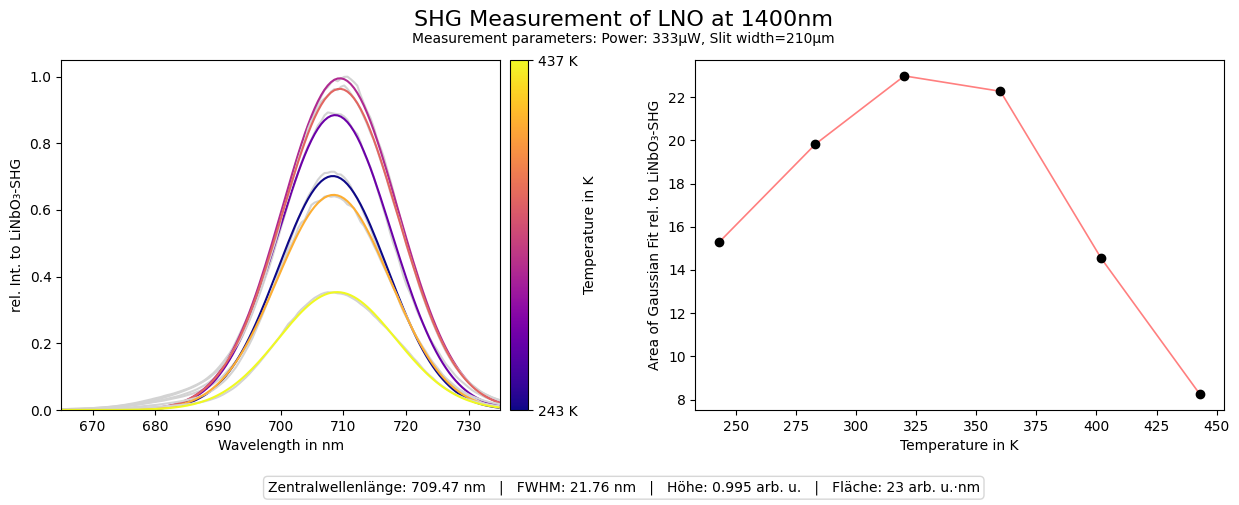

In [13]:
create_shg_plot(
    middle_value=700,
    difference=35,
    filepath='2025-05-23 LNO/1400nm/0.333mW_Spalt210um/*.asc',
    suptitle='SHG Measurement of LNO at 1400nm',
    filename_prefix='LNO_SHG',
    reference=True
)

### THG

Absolute maximum in raw data within x_range (432, 502): 64109.0


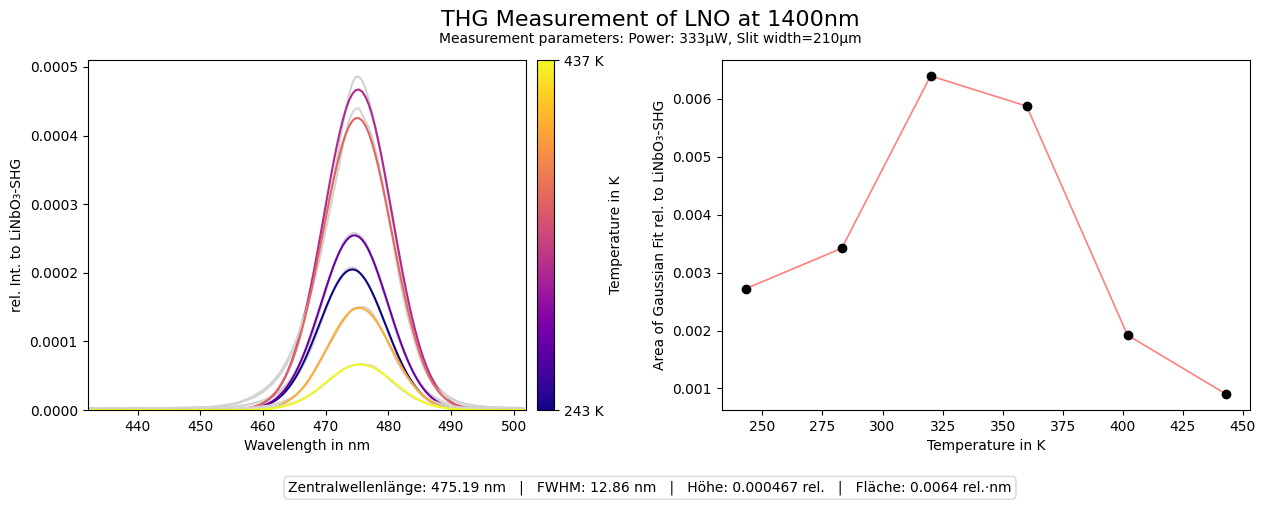

In [14]:
create_shg_plot(
    middle_value=467,
    difference=35,
    filepath='2025-05-23 LNO/1400nm/0.333mW_Spalt210um/*.asc',
    suptitle='THG Measurement of LNO at 1400nm',
    filename_prefix='LNO_THG'
)

## TIBI

### SHG

Absolute maximum in raw data within x_range (665, 735): 44702.0


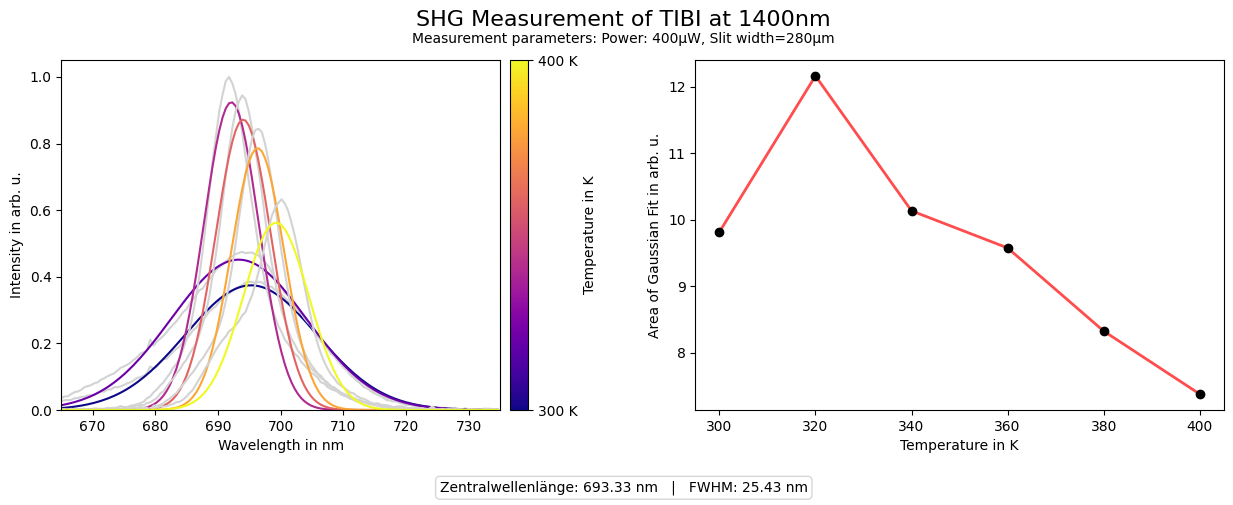

In [15]:
create_shg_plot(
    middle_value=700,
    difference=35,
    filepath='TIBI_400uW_1400nm/*.asc',
    suptitle='SHG Measurement of TIBI at 1400nm',
    filename_prefix='TIBI_SHG',
    power="400µW",
    slit_width="280µm",
    compare=False,
    reference=False
)

### THG

Absolute maximum in raw data within x_range (277, 657): 502.0


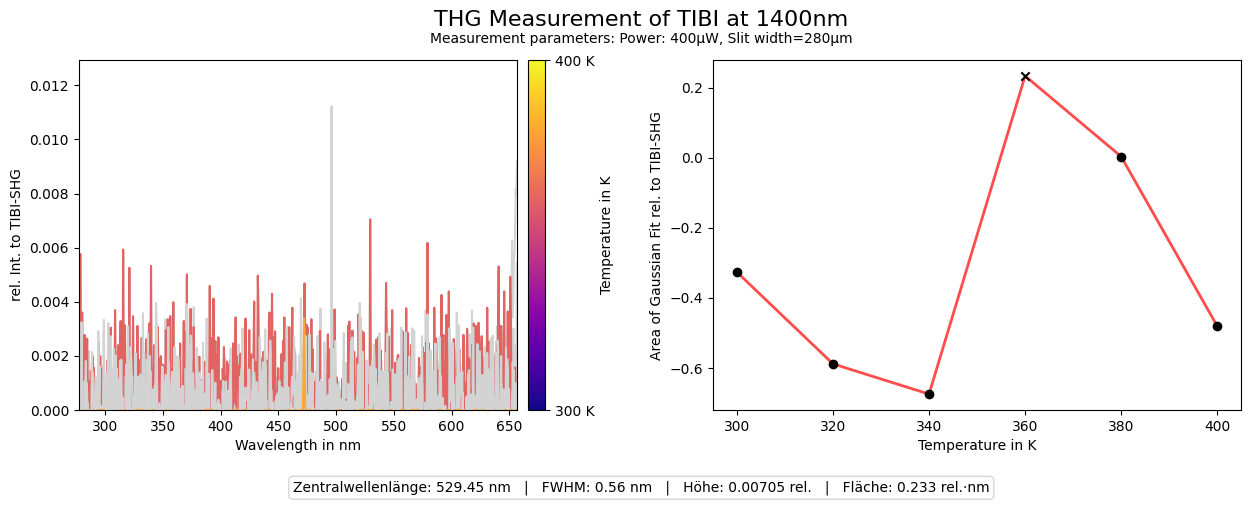

In [16]:
create_shg_plot(
    middle_value=467,
    difference=190,
    filepath='TIBI_400uW_1400nm/*.asc',
    suptitle='THG Measurement of TIBI at 1400nm',
    filename_prefix='TIBI_THG',
    power="400µW",
    slit_width="280µm",
    compare=True,
    normalisationfactor=44702.0,
    refmeas="TIBI-SHG"
)

## TISI

### SHG

Absolute maximum in raw data within x_range (665, 735): 162541.0


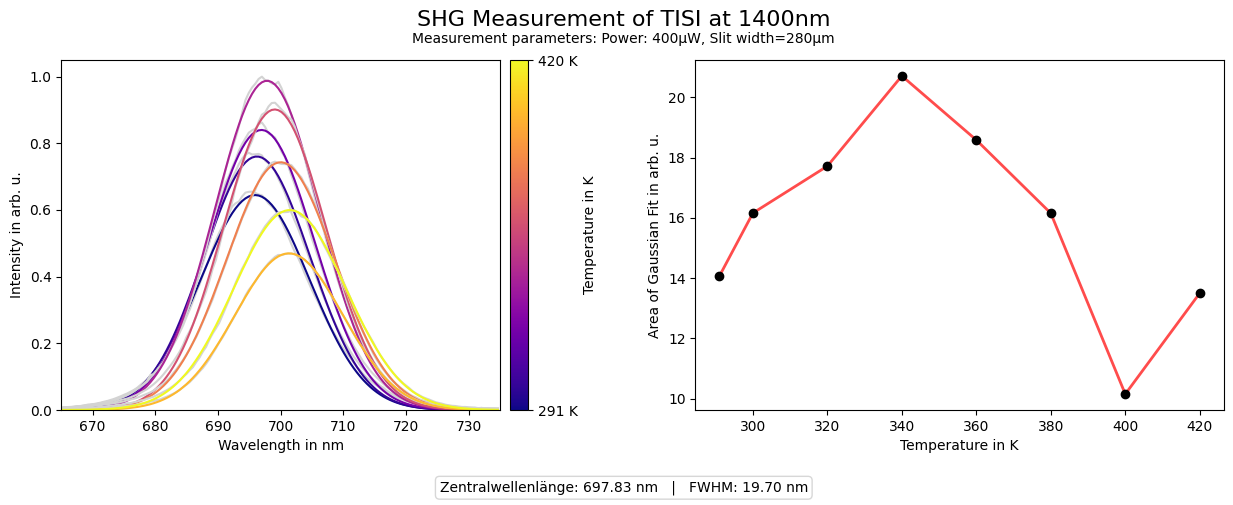

In [17]:
create_shg_plot(
    middle_value=700,
    difference=35,
    filepath='TISI_400uW_1400nm/*.asc',
    suptitle='SHG Measurement of TISI at 1400nm',
    filename_prefix='TISI_SHG',
    power="400µW",
    slit_width="280µm",
    compare=False,
    reference=False
)

### THG

Absolute maximum in raw data within x_range (277, 657): 699.0


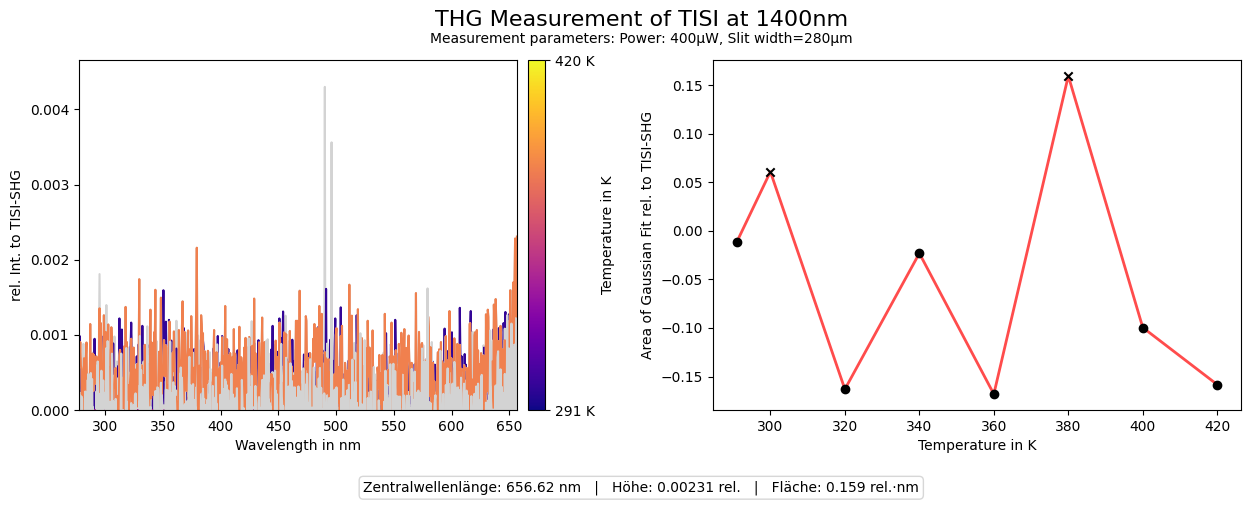

In [18]:
create_shg_plot(
    middle_value=467,
    difference=190,
    filepath='TISI_400uW_1400nm/*.asc',
    suptitle='THG Measurement of TISI at 1400nm',
    filename_prefix='TISI_THG',
    power="400µW",
    slit_width="280µm",
    compare=True,
    normalisationfactor=162541.0,
    refmeas="TISI-SHG"
)